# A Dog Classification Model using Bing Images

Below is one of my proudest works, a classification model with inputs from Bing Images.
Thanks to Jeremy Howard and his Fast AI course for teaching me the fundamentals of PyTorch and classification modelling.

First we import the fastbook package and the `bing_image_downloader`:

In [29]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from fastai.vision.widgets import *
!pip install bing-image-downloader
from bing_image_downloader import downloader

Then we download the dog photos. I capped them to 150 for each breed to not sit here for 35 hours waiting for my model to finish training.

In [30]:
downloader.download("beagle dog", limit=150, output_dir='dogs', adult_filter_off=True, force_replace=False, timeout=5)
downloader.download("husky dog", limit=150, output_dir='dogs', adult_filter_off=True, force_replace=False, timeout=5)
downloader.download("german shepherd dog", limit=150, output_dir='dogs', adult_filter_off=True, force_replace=False, timeout=5)

[%] Downloading Images to /notebooks/dogs/beagle dog


[!!]Indexing page: 1

[%] Indexed 150 Images on Page 1.


[%] Downloading Image #1 from https://cdn.shopify.com/s/files/1/2294/6747/products/DSC02291.JPG?v=1571727888
[%] File Downloaded !

[%] Downloading Image #2 from http://www.dogzone.com/images/breeds/beagle-puppy.jpg
[%] File Downloaded !

[%] Downloading Image #3 from https://2.bp.blogspot.com/-nsmQAFw-ivE/UFGwPri3dyI/AAAAAAAAAag/dcFqve-HgFY/s1600/The+Beagle+Dog2.jpg
[%] File Downloaded !

[%] Downloading Image #4 from https://greengarageblog.org/wp-content/uploads/2020/07/australian-cattle-dog-beagle-mix-768x480.jpg
[%] File Downloaded !

[%] Downloading Image #5 from https://images.wagwalkingweb.com/media/training_guides/not-bark/hero/How-to-Train-Your-Beagle-Dog-to-Not-Bark.jpg
[%] File Downloaded !

[%] Downloading Image #6 from https://www.publicdomainpictures.net/pictures/50000/velka/beagle-puppy-1370102031HHG.jpg
[%] File Downloaded !

[%] Downloading Image #7 from ht

Next, we rename the paths created by the downloader for clarity.

In [31]:
path1 = Path('dogs/beagle dog')
path1.rename('dogs/beagle')
path2 = Path('dogs/husky dog')
path2.rename('dogs/husky')
path3 = Path('dogs/german shepherd dog')
path3.rename('dogs/germanshepherd')

Let's see if the images downloaded correctly.

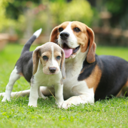

In [32]:
dest = "dogs/beagle/Image_10.jpeg"
im = Image.open(dest)
im.to_thumb(128,128)

That's a cute pair of beagles. Let's make sure we have the right amount of images. 150 photos * 3 searches should give us a total of 450 images altogether.

In [35]:
path = Path("dogs")

fns = get_image_files(path)
fns

(#450) [Path('dogs/husky/Image_118.jpg'),Path('dogs/husky/Image_32.jpg'),Path('dogs/husky/Image_90.jpeg'),Path('dogs/husky/Image_149.jpeg'),Path('dogs/husky/Image_93.jpg'),Path('dogs/husky/Image_30.jpg'),Path('dogs/husky/Image_143.jpg'),Path('dogs/husky/Image_73.jpg'),Path('dogs/husky/Image_45.jpeg'),Path('dogs/husky/Image_29.jpg')...]

Beautiful. Now let's check if any of the images are corrupt. Often when downloading raw images from Bing it's normal to have a couple corrupt guys.

In [36]:
failed = verify_images(fns)
failed

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(#0) []

Although there are no corrupt images, let's unlink them anyway just out of good practice and habit.

In [37]:
failed.map(Path.unlink)

(#0) []

Nice. Now let's chef up a DataBlock to get our train and valid sets.

For our independent variable we will use `ImageBlock`, our set of images.
For the dependent variable, it will be the category of dog (or the breed).

Let's split up the data into the two sets. We assign 0.2 to `valid_pct` for our validation set. We also assign a seed to make sure every time the notebook is ran we obtain the same validation set.

For our `parent_label`, we want to use the dependent variable, i.e the dog breed.

Lastly, we assign the same image size to all the data in our tensor. 128 pixels it is.

In [38]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Now we load it into the DataLoader. 

In [40]:
dls = dogs.dataloaders(path)

Let's check out a portion of the tensor to make sure all my dawgs have loaded correctly.

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:819: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


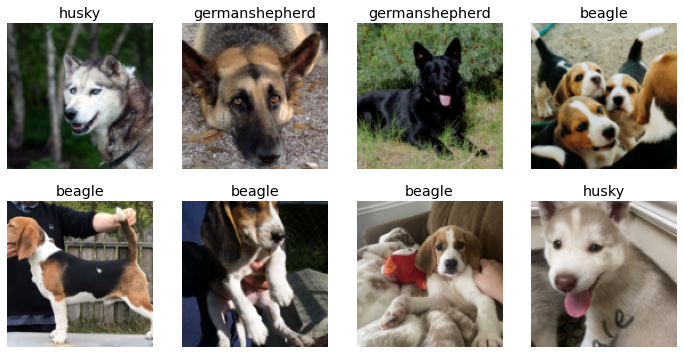

In [41]:
dls.valid.show_batch(max_n=8, nrows=2)

Now I want to make sure that all the photos are resized and cropped to the same size.

In [42]:
dogs = dogs.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = dogs.dataloaders(path)

And now all the data loading is done, on to the good stuff. Let's create our learner. I'm using the standard architecture used in the Fast AI course for the sake of simplicity.

Next, we want to fine-tune it to make sure the model is working the way we want it to.

In [43]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.7/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.338602,0.054858,0.022222,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.117257,0.025915,0.011111,00:16
1,0.081953,0.018089,0.011111,00:14
2,0.080802,0.019497,0.011111,00:14
3,0.062295,0.024552,0.011111,00:18


Looking at the results, we see our loss is mostly decreasing across epochs, which is a good sign. The error rate seems to be stable at 0.1111, not entirely sure why that is. Maybe it just got it absolutely right the first time it was fine-tuned.

To see where this 0.1111 error rate is, next I plot a confusion matrix to see where our model misidentified our dawgs.

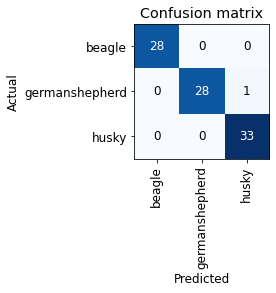

In [44]:
interpret = ClassificationInterpretation.from_learner(learn)
interpret.plot_confusion_matrix()

Amazing. It got pretty much everything right apart from 1 dude: it was a german shepherd but the model incorrectly predicted it to be a husky.

Let's take a look at this decieving doge.

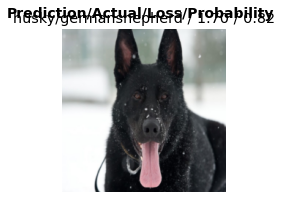

In [47]:
interpret.plot_top_losses(1, nrows=1)

To be honest, that dog could pass as a black-fur husky from far away. Is there such a thing?

Anyways, that's it! Pretty happy with how it went, classifiers are pretty cool. On to the next.